(multivariate_gaussian_effect_sizes_across_demes_vignette)=

# The multivariate Gaussian distribution

In [1]:
import demes
import demesdraw
import fwdpy11
import numpy as np

We may model Gaussian effect sizes using the existing {class}`fwdpy11.MultivariateGaussianEffects`
in conjunction with {class}`fwdpy11.mvDES`.

At this time, it is probably best to look at an example. The following code models Gaussian stabilizing
selection on a quantitative trait.  The effects sizes within each deme are themselves given by Gaussian
distributions and there is no correlation in the effect size in the two demes.

We will simulate a demographic model of migration happening into the infinite past of two equal-sized demes:

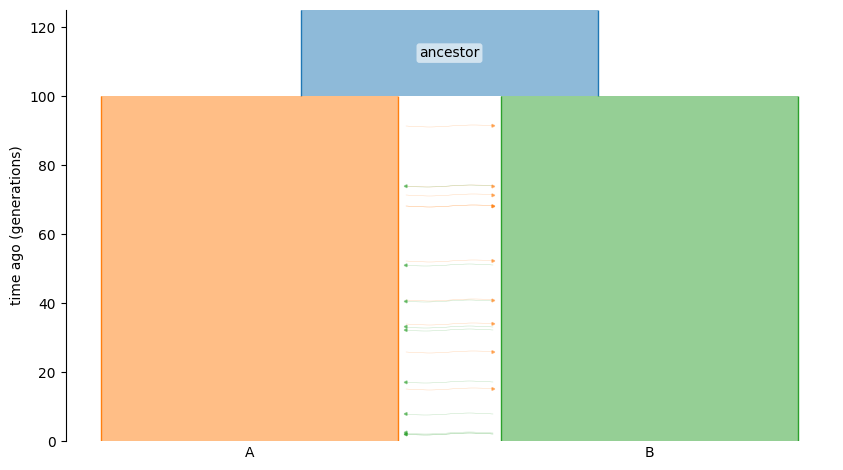

In [2]:
yaml = """
description: Island model forever
time_units: generations
demes:
  - name: ancestor
    epochs:
     - start_size: 100
       end_time: 100
  - name: A
    ancestors: [ancestor]
    epochs:
     - start_size: 100
  - name: B
    ancestors: [ancestor]
    epochs:
     - start_size: 100
migrations:
  - demes: [A, B]
    rate: 0.10
"""
g = demes.loads(yaml)
model = fwdpy11.discrete_demography.from_demes(g, burnin=1)
demesdraw.tubes(g);

Let's set up a dictionary to hold the parameters of our model:

In [3]:
pdict = {
    "nregions": [],
    "recregions": [],
    "sregions": [
        fwdpy11.mvDES(
            fwdpy11.MultivariateGaussianEffects(0, 1, 1, np.identity(3)), np.zeros(3)
        )
    ],
    "rates": (0, 2.5e-3, None),
    "demography": model,
    "simlen": model.metadata["total_simulation_length"],
    "gvalue": fwdpy11.Additive(
        ndemes=3, scaling=2, gvalue_to_fitness=fwdpy11.GSS(optimum=0.0, VS=10.0)
    ),
}

Most of the above is standard.  Let's dissect the new bits:

* An instance of {class}`fwdpy11.mvDES` is our only region with selected mutations.
* This instance holds an instance of {class}`fwdpy11.MultivariateGaussianEffects`
  that puts mutations on the interval {math}`[0, 1)` with weight 1 and an identity
  matrix specifies the correlation in effect sizes between demes 0 and 1.  The
  identity matrix has the value zero for all off-diagonal elements, meaning
  no covariance in effect sizes across demes.
* The final constructor argument specifies the mean of each marginal Gaussian
  distribution. The means are both zero.
* Our genetic value type accepts an `ndemes` parameter, telling it that it has
  to look for deme-specific effect sizes.  This value must be set to the maximum
  number of demes that will exist during a simulation.

Let's evolve the model now:

In [4]:
params = fwdpy11.ModelParams(**pdict)
# TODO: update this once we have a function to pull the sizes
# automatically from demes-derived models:
initial_sizes = [v for v in model.metadata["initial_sizes"].values()]
pop = fwdpy11.DiploidPopulation(initial_sizes, 1.0)
rng = fwdpy11.GSLrng(1010)
fwdpy11.evolvets(rng, pop, params, 10)

Let's extract the effect sizes from each deme:

In [5]:
assert len(pop.tables.mutations) > 0
for i in pop.tables.mutations:
    print(pop.mutations[i.key].esizes)

[ 1.33393583 -1.42671084  2.37936694]
[ 0.74651187  0.20938071 -0.7841031 ]
[ 0.32575285  0.35069963 -0.11465527]
[-0.24181509  1.00965354  0.68807326]
[ 1.17357808  0.63700908 -2.40771662]
[-0.22207726  0.23289436  0.92726017]
[ 0.24505205  0.73996041 -0.70205993]
[ 0.5018422   0.50924973 -0.10140017]
[-0.22408902  0.83343064 -0.2691579 ]


Let's look at another example where effect sizes covary negatively across demes and raise the mutation rate a bit:

In [6]:
# Effect sizes across demes will
# have a correlation coefficient of r=1/2
cor_matrix = np.array([-0.5]*9).reshape(3,3)
np.fill_diagonal(cor_matrix, np.array([1.0]*3))

# Get our covariance matrix
sd = np.array([0.1]*3)
D = np.identity(3)
np.fill_diagonal(D, sd)
vcv_matrix = np.matmul(np.matmul(D, cor_matrix), D)
pdict["sregions"] = [
    fwdpy11.mvDES(fwdpy11.MultivariateGaussianEffects(0, 1, 1, vcv_matrix), np.zeros(3))
]
params = fwdpy11.ModelParams(**pdict)
# TODO: update this once we have a function to pull the sizes
# automatically from demes-derived models:
initial_sizes = [v for v in model.metadata["initial_sizes"].values()]
pop = fwdpy11.DiploidPopulation(initial_sizes, 1.0)
fwdpy11.evolvets(rng, pop, params, 10)
for i in pop.tables.mutations:
    print(pop.mutations[i.key].esizes)

[-0.07440418  0.03966954  0.03473464]
[ 0.07414971  0.06569778 -0.13984749]
[ 0.07593905 -0.04116704 -0.03477201]
[ 0.13958957 -0.22582578  0.08623621]
[-0.02982778  0.0895709  -0.05974312]
[-0.08529108  0.14513978 -0.05984871]
[ 0.06425309  0.01562452 -0.07987761]
[ 0.01898601  0.07154382 -0.09052983]


Now we see that the effect sizes often differ in sign between the two demes.